# Subgroup Robustness Grows on Trees (Experiments)
Here are some initial experiments corroborating the empirical observations from *Subgroup Robustness Grows on Trees*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

## Datasets
We'll run experiments on three datasets typically used in the fairness and robustness literature:

1. Adult (*medium*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Income (*large*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
3. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We will also do experiments with a fourth synthetic dataset that has overlapping group structure.

### Adult Dataset
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

In [2]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def produce_group_adult(race_val, sex_val):
    def f(x):
        return (x['race'] == race_val) & (x['sex'] == sex_val)
    def f_notwhite(x):
        return (x['race'] != 'White') & (x['sex'] == sex_val)
    
    if race_val == "NotWhite":
        return f_notwhite
    else:
        return f
    
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

# define group functions
group_names_coarse = list()
groups_coarse = list()
group_indices_coarse = list()
race_gps_coarse = ["White", "NotWhite"]
race_gps_fine = ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]
sex_gps = ["Male", "Female"]
for race in race_gps_coarse:
    for sex in sex_gps:
        group_names_coarse.append((race, sex))
        groups_coarse.append(produce_group_adult(race, sex))
        group_indices_coarse.append(adult_gp_indices(X, race, sex)[0])

group_names_fine = list()
groups_fine = list()
group_indices_fine = list()
for race in race_gps_fine:
    for sex in sex_gps:
        group_names_fine.append((race, sex))
        groups_fine.append(produce_group_adult(race, sex))
        group_indices_fine.append(adult_gp_indices(X, race, sex)[0])

def all_losses(X, y, model):
	# define evaluation procedure
	cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

def group_losses(X, y, model, gp_indices):
    # define evaluation procedure
    cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    
    gp_scores = []
    for indices in gp_indices:
        scores = cross_val_score(model, X.iloc[indices], y[indices], 
                                scoring='accuracy', cv=cv, n_jobs=-1)
        gp_scores.append(scores)

    return gp_scores

print("Group Names (Coarse): {}".format(group_names_coarse))
print("Group Names (Fine): {}".format(group_names_fine))

Group Names (Coarse): [('White', 'Male'), ('White', 'Female'), ('NotWhite', 'Male'), ('NotWhite', 'Female')]
Group Names (Fine): [('White', 'Male'), ('White', 'Female'), ('Asian-Pac-Islander', 'Male'), ('Asian-Pac-Islander', 'Female'), ('Amer-Indian-Eskimo', 'Male'), ('Amer-Indian-Eskimo', 'Female'), ('Other', 'Male'), ('Other', 'Female'), ('Black', 'Male'), ('Black', 'Female')]


In [4]:
# Prepend testing
from prepend.prepend_algo import sort_groups
sorted_X, sorted_y = sort_groups(X, y, groups_coarse)

col_transf.fit(X)
X_transf = col_transf.transform(X)
print(X_transf.shape)
for g in range(len(groups_coarse)):
    curr_X = col_transf.transform(sorted_X[g])
    print(curr_X.shape)

(45222, 104)
(27020, 104)
(11883, 104)
(3507, 104)
(2812, 104)


In [9]:
def default_group(x):
    return (x)  # always True

'''
Checks if a batch of examples falls in a group.
input: X (np.ndarray, the examples), group (Boolean function)
output: membership (np.ndarray of Boolean values, len(X) long)
'''
def group_check(X, group):
    membership = np.zeros_like(range(len(X)), dtype=bool)
    membership[np.where(group(X))[0]] = True
    return membership

group_check(X, default_group)

array([ True,  True,  True, ...,  True,  True,  True])

In [5]:
# Prepend testing
from prepend.prepend_algo import prepend_algo
from sklearn.svm import SVC
from sklearn.metrics import zero_one_loss

params = {
    "gamma": 'scale'
}
dec_list = prepend_algo(X, y, SVC, zero_one_loss, groups_coarse, transformer=col_transf, params=params, verbose=True)

fitting for group 0
group 0 has 27020 examples.
fitting for group 1
group 1 has 11883 examples.
fitting for group 2
group 2 has 3507 examples.
fitting for group 3
group 3 has 2812 examples.
grp_indices:[ True False False False False]
length of grp_indices:27020
len of not_predicted_yet: 27020
[ True False False ... False False False]
<class 'pandas.core.frame.DataFrame'>
1
<class 'scipy.sparse._csr.csr_matrix'>
shape of transformed: (1, 104)
final y_pred: [ 0. nan nan ... nan nan nan]


ValueError: Input y_true contains NaN.

## Fit and Evaluate Models

In [178]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def model_suite():
    models = []
    names = []

    # Decision Tree
    models.append(DecisionTreeClassifier())
    names.append("Decision Tree (single, CART)")

    # SVM
    models.append(SVC(gamma="scale"))
    names.append("SVM")

    # Logistic Regression
    models.append(LogisticRegression())
    names.append("Logistic Regression")

    # Random Forest
    num_trees = [64, 128, 256, 512, 1024]
    for n in num_trees:
        models.append(RandomForestClassifier(n_estimators=n))
        names.append("Random Forests ({} trees)".format(n))
    
    # Gradient Boosting
    for n in num_trees:
        models.append(GradientBoostingClassifier(n_estimators=n))
        names.append("Gradient Boosting ({} trees)".format(n))

    return models, names

In [179]:
from numpy import mean
from numpy import std

models, model_names = model_suite()
results = list() # list of dictionaries of 6 scores

for i in range(len(models)):
    pipe = Pipeline([('col_transf', col_transf), (model_names[i], models[i])])

    # Evaluate model per group
    print("Model: {}".format(model_names[i]))
    mean_gp_scores = []
    group_scores = group_losses(X, y, pipe, group_indices)
    for group_score in group_scores:
        mean_gp_scores.append(mean(group_score))
    worst_gp_score = min(mean_gp_scores)
    all_scores = mean(all_losses(X, y, pipe))
    for j in range(len(mean_gp_scores)):
        print("Group ({}) Accuracy: {}".format(group_names[j], mean_gp_scores[j]))
    print("Worst Group Accuracy: {}".format(worst_gp_score))
    print("Overall Accuracy: {}".format(all_scores))
    print()

    # Save results
    result = dict()
    result['group_accs'] = mean_gp_scores
    result['worst_group'] = worst_gp_score
    result['avg_acc'] = all_scores
    results.append(result)

Model: Decision Tree (single, CART)
Group (('White', 'Male')) Accuracy: 0.7614359733530718
Group (('White', 'Female')) Accuracy: 0.894050376149661
Group (('NotWhite', 'Male')) Accuracy: 0.8209354971123874
Group (('NotWhite', 'Female')) Accuracy: 0.9064708001744594
Worst Group Accuracy: 0.7614359733530718
Overall Accuracy: 0.8110212708632375

Model: SVM
Group (('White', 'Male')) Accuracy: 0.7910436713545522
Group (('White', 'Female')) Accuracy: 0.9083567762890439
Group (('NotWhite', 'Male')) Accuracy: 0.8354788234959418
Group (('NotWhite', 'Female')) Accuracy: 0.932430484883346
Worst Group Accuracy: 0.7910436713545522
Overall Accuracy: 0.8362965872392424

Model: Logistic Regression


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Group (('White', 'Male')) Accuracy: 0.803960029607698
Group (('White', 'Female')) Accuracy: 0.9142475802761878
Group (('NotWhite', 'Male')) Accuracy: 0.8448886612937969
Group (('NotWhite', 'Female')) Accuracy: 0.9352736673767248
Worst Group Accuracy: 0.803960029607698
Overall Accuracy: 0.847308997789567

Model: Random Forests (1 trees)
Group (('White', 'Male')) Accuracy: 0.7478164322723908
Group (('White', 'Female')) Accuracy: 0.8886652955016439
Group (('NotWhite', 'Male')) Accuracy: 0.7844247737257722
Group (('NotWhite', 'Female')) Accuracy: 0.9096793360429322
Worst Group Accuracy: 0.7478164322723908
Overall Accuracy: 0.8006500961211926

Model: Random Forests (2 trees)
Group (('White', 'Male')) Accuracy: 0.7734270910436714
Group (('White', 'Female')) Accuracy: 0.905327004443538
Group (('NotWhite', 'Male')) Accuracy: 0.8189355052407835
Group (('NotWhite', 'Female')) Accuracy: 0.926385719613408
Worst Group Accuracy: 0.7734270910436714
Overall Accuracy: 0.8215693486960989

Model: Random 

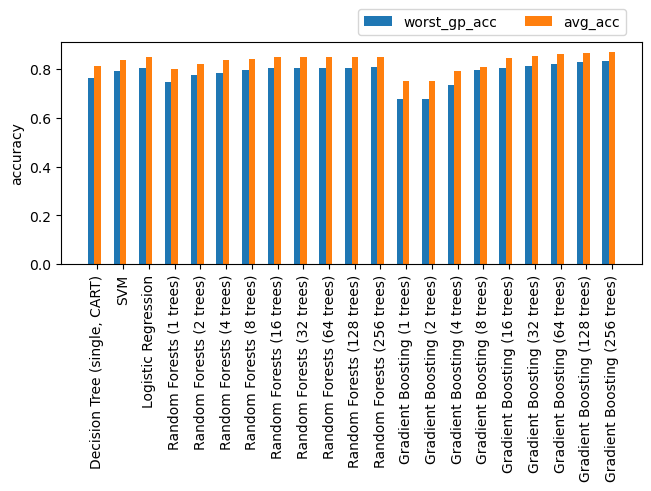

In [209]:
# Plot these initial results
x = np.arange(len(model_names))
width = 0.25
multiplier = 0

accuracies = {
    #'g0_acc': [],
    #'g1_acc': [],
    #'g2_acc': [],
    #'g3_acc': [],
    'worst_gp_acc': [],
    'avg_acc': []
}
for result in results:
    #accuracies['g0_acc'].append(result['group_accs'][0])
    #accuracies['g1_acc'].append(result['group_accs'][1])
    #accuracies['g2_acc'].append(result['group_accs'][2])
    #accuracies['g3_acc'].append(result['group_accs'][3])
    accuracies['worst_gp_acc'].append(result['worst_group'])
    accuracies['avg_acc'].append(result['avg_acc'])

fig, ax = plt.subplots(layout='constrained')
for acc, val in accuracies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, val, width, label=acc)
    multiplier += 1

ax.set_ylabel("accuracy")
ax.set_xticks(x + width, model_names, rotation=90)
ax.legend(loc='best', bbox_to_anchor=(0.5, 1), ncols=3)
plt.show()

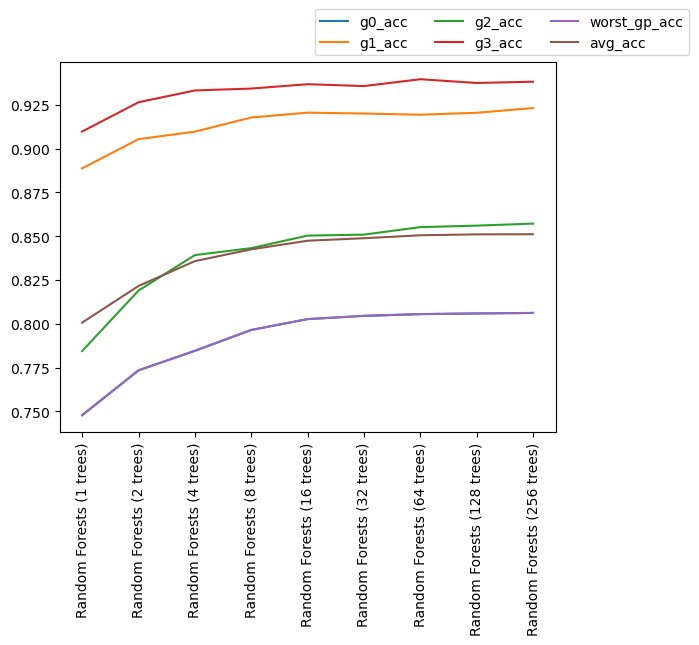

In [228]:
# Plot only for Random Forests with different n_estimators
rf_accuracies = {
    'g0_acc': [],
    'g1_acc': [],
    'g2_acc': [],
    'g3_acc': [],
    'worst_gp_acc': [],
    'avg_acc': []
}
rf_names = model_names[3:12]
rf_results = results[3:12]

for result in rf_results:
    rf_accuracies['g0_acc'].append(result['group_accs'][0])
    rf_accuracies['g1_acc'].append(result['group_accs'][1])
    rf_accuracies['g2_acc'].append(result['group_accs'][2])
    rf_accuracies['g3_acc'].append(result['group_accs'][3])
    rf_accuracies['worst_gp_acc'].append(result['worst_group'])
    rf_accuracies['avg_acc'].append(result['avg_acc'])

for acc, val in rf_accuracies.items():
    plt.plot(rf_names, val, label=acc)

plt.xticks(rf_names, rotation=90)
plt.legend(loc='best', bbox_to_anchor=(0.5, 1), ncols=3)
plt.show()

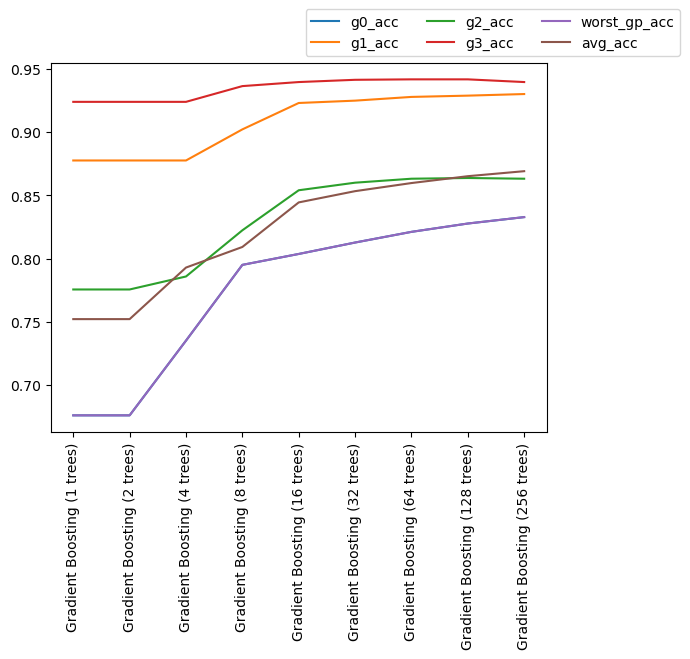

In [232]:
# Plot only for Gradient Boosting with different n_estimators
gb_accuracies = {
    'g0_acc': [],
    'g1_acc': [],
    'g2_acc': [],
    'g3_acc': [],
    'worst_gp_acc': [],
    'avg_acc': []
}
gb_names = model_names[12:]
gb_results = results[12:]

for result in gb_results:
    gb_accuracies['g0_acc'].append(result['group_accs'][0])
    gb_accuracies['g1_acc'].append(result['group_accs'][1])
    gb_accuracies['g2_acc'].append(result['group_accs'][2])
    gb_accuracies['g3_acc'].append(result['group_accs'][3])
    gb_accuracies['worst_gp_acc'].append(result['worst_group'])
    gb_accuracies['avg_acc'].append(result['avg_acc'])

for acc, val in gb_accuracies.items():
    plt.plot(gb_names, val, label=acc)

plt.xticks(gb_names, rotation=90)
plt.legend(loc='best', bbox_to_anchor=(0.5, 1), ncols=3)
plt.show()